## Calculate ratios and relative abundances of important proteins

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = None

### Read intensities from Excel sheet

In [2]:
# Read log2-transformed LFQ intensity from shaving data
shaving = pd.read_excel('input_files/20220216_identified_quantified_proteins_shaving.xlsx', #noqa: E501
                   sheet_name = 'quantified_proteins',
                   header = 1)

# Read Z-score abundance from supernatant data
sn = pd.read_excel('input_files/20220428_identified_quantified_supernatant.xlsx',
                   sheet_name = 'quantified_proteins',
                   header = 1)

# Fix stupid names with spaces
shaving.columns = shaving.columns.str.replace(' ', '')
sn.columns = sn.columns.str.replace(' ', '')

shaving = shaving[:-1]
sn = sn[:-1]

### Define Conditions

In [3]:
# late stationary phase
include_dict = {'Fructose_20h': ['F20_1','F20_2','F20_3'],
                'RS_20h': ['resistantS20_1','resistantS20_2','resistantS20_3'],
                'Pullulan_20h': ['P20_1','P20_2','P20_3'],
                'Starch_20h': ['S20_1','S20_2','S20_3']}

# Protein ID should always be there
include_conditions = []

for conditions in include_dict.values():
    include_conditions = include_conditions + conditions

# Let's make a minimal dataframe, 20h Fruc vs. 20h RS
shaving = shaving[['MajorityproteinIDs', *include_conditions]]
sn = sn[['MajorityproteinIDs', *include_conditions]]

# Drop all proteins which are not identified in any triplicate of any condition
protein_identified_shaving = shaving[include_conditions].notna().any(axis=1)
shaving = shaving[protein_identified_shaving]

protein_identified_sn = sn[include_conditions].notna().any(axis=1)
sn = sn[protein_identified_sn]

In [4]:
# Add mean abundance
conditions_mean = {}

for key, value in include_dict.items():
    name_mean = f'{key}_mean'
    conditions_mean[key] = name_mean

    shaving[name_mean] = shaving[value].mean(axis=1, skipna = True)
    sn[name_mean] = sn[value].mean(axis=1, skipna = True)

### Calculate Shares of Amylosome components

In [6]:
# Load full protein info
full_sequences = pd.read_csv("input_files/sequences_annotated.csv",
                            index_col = 0)

# Merge
shaving_annotated = shaving.merge(full_sequences[['SeqID',
                                                  'shortname',
                                                  'amylosome_component',
                                                  'amylosome_category']],
                                  left_on = 'MajorityproteinIDs',
                                  right_on = 'SeqID',
                                  how = 'left',
                                  validate = '1:m')

sn_annotated = sn.merge(full_sequences[['SeqID',
                                        'shortname',
                                        'amylosome_component',
                                        'amylosome_category']],
                        left_on = 'MajorityproteinIDs',
                        right_on = 'SeqID',
                        how = 'left',
                        validate = '1:m')

# Make Dataset of Dockerin-containing enzymes
shaving_annotated.amylosome_component = shaving_annotated.amylosome_component.astype('boolean') #noqa: E501
sn_annotated.amylosome_component = sn_annotated.amylosome_component.astype('boolean')

#### Cell-associated

In [7]:
comp_doc = shaving_annotated[shaving_annotated.amylosome_component]

# Results DataFrame
share_doc = pd.DataFrame()

for col in include_conditions:
    name = f'{col}_raw'

    # Backtransform log2-transformed LFQ values.
    comp_doc[name] = 2 ** comp_doc[col]

    # Calculate share for each protein
    for spe_id in shaving_annotated[shaving_annotated.amylosome_component]["SeqID"].to_list(): #noqa: E501
        share_doc.loc[col, spe_id] = float(comp_doc[comp_doc.SeqID == spe_id][name].item()) / comp_doc[name].sum()*100 #noqa: E501

#### Supernatant

In [8]:
sn_doc = sn_annotated[sn_annotated.amylosome_component]

# Results DataFrame
share_doc_sn = pd.DataFrame()

for col in include_conditions:
    name = f'{col}_raw'

    # As suggested by Anke, set lowest value to 0 and then to %
    sn_doc[name] = sn_doc[col] - sn_doc[col].min()

    # Calculate share for each protein
    for spe_id in sn_annotated[sn_annotated.amylosome_component]["SeqID"].to_list():
        share_doc_sn.loc[col, spe_id] = float(sn_doc[sn_doc.SeqID == spe_id][name].item()) / sn_doc[name].sum()*100 #noqa: E501

### Cluster into Useful Groups

In [9]:
comp_doc.loc[comp_doc.amylosome_category.isna(), "amylosome_category"] = "Other"
sn_doc.loc[sn_doc.amylosome_category.isna(), "amylosome_category"] = "Other"

In [10]:
clustered_df = pd.DataFrame()
clustered_df_sn = pd.DataFrame()


for cat in comp_doc.amylosome_category.unique():
    protein_list = comp_doc[comp_doc.amylosome_category
                            == cat].MajorityproteinIDs.to_list()

    clustered_df[cat] = share_doc[protein_list].sum(axis=1)

for cat in sn_doc.amylosome_category.unique():
    protein_list = sn_doc[sn_doc.amylosome_category
                          == cat].MajorityproteinIDs.to_list()

    clustered_df_sn[cat] = share_doc_sn[protein_list].sum(axis=1)

clustered_mean = clustered_df.groupby(clustered_df.index.str[0]).mean()
clustered_mean_sn = clustered_df_sn.groupby(clustered_df_sn.index.str[0]).mean()

### Plot

In [11]:
clustered_mean = clustered_mean.reindex(["F","S","P","r"])
clustered_mean_sn = clustered_mean_sn.reindex(["F","S","P","r"])

clustered_mean = clustered_mean.reindex(columns = ["Amy4",
                                                   "Amy9",
                                                   "Amy16",
                                                   "Amy10",
                                                   "Amy12",
                                                   "Sas",
                                                   "Sca",
                                                   "Protease",
                                                   "Other"])

clustered_mean_sn = clustered_mean_sn.reindex(columns = ["Amy4",
                                                   "Amy9",
                                                   "Amy16",
                                                   "Amy10",
                                                   "Amy12",
                                                   "Sas",
                                                   "Sca",
                                                   "Protease",
                                                   "Other"])

#### Paper

In [12]:
cmap = {'Amy4': "#01665e",
        'Amy9': "#5ab4ac",
        'Amy16': "#c7eae5",
        'Amy10': "#d8b365",
        'Amy12': "#8c510a",
        'Sas': "#af8dc3",
        'Sca': "#b2182b",
        'Protease': "#969696",
        'Other': '#cccccc'}

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18750/2909211256.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = ax.get_yticklabels(),
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18750/2909211256.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=samples,


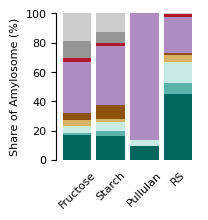

In [14]:
inch = 2.54 # one inch is 2.54 cm

fig, ax = plt.subplots(figsize=(5.5 / inch,
                                5.8 / inch))

bottom = np.zeros(4)

samples = ["Fructose",
           "Starch",
           "Pullulan",
           "RS"]

for protein, row in clustered_mean.T.iterrows():
    p = ax.bar(samples,
               row.values,
               0.85,
               label=protein,
               bottom=bottom,
               color = cmap[protein]
               )
    bottom += row.values

ax.set_ylabel("Share of Amylosome (%)",
              fontsize = 8)
ax.set_ylim([0,100])
ax.set_yticklabels(labels = ax.get_yticklabels(),
                  fontsize = 8)


ax.set_xlabel('')
ax.set_xticklabels(labels=samples,
                   rotation = 45,
                   fontsize = 8,)

ax.xaxis.set_ticks_position('none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.tight_layout(pad=1)

#### SI

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18750/2693478987.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=samples,
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18750/2693478987.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = ax.get_yticklabels(),


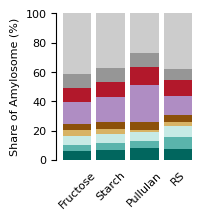

In [15]:
inch = 2.54 # one inch is 2.54 cm

fig, ax = plt.subplots(figsize=(5.5 / inch,
                                5.8 / inch))

bottom = np.zeros(4)

samples = ["Fructose",
           "Starch",
           "Pullulan",
           "RS"]

for protein, row in clustered_mean_sn.T.iterrows():
    p = ax.bar(samples,
               row.values,
               0.85,
               label=protein,
               bottom=bottom,
               color = cmap[protein],
               )
    bottom += row.values

ax.set_ylabel("Share of Amylosome (%)",
              fontsize = 8)
ax.set_ylim([0,100])


ax.set_xlabel('')
ax.set_xticklabels(labels=samples,
                   rotation = 45,
                   fontsize = 8,)

ax.xaxis.set_ticks_position('none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_yticklabels(labels = ax.get_yticklabels(),
                  fontsize = 8)

fig.tight_layout(pad=1)